In [1]:
import torch.nn as nn
import torch.optim as optim
import torch_geometric.utils
import torch, random, torchaudio, os, time, math, torch_geometric
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
import networkx as nx
from torchvision import transforms as transforms
import torchaudio.transforms as audio_transforms
import datasets
from torch.utils.data import random_split, DataLoader
import utils

sample_rate = 16000
resample_rate = 8000
args = utils.Args(seed=42)

if args.device != "cpu":
    num_workers = 1
    pin_memory = True
    torch.cuda.manual_seed(args.seed)
else:
    num_workers = 0
    pin_memory = False
    torch.manual_seed(args.seed)

mimii_dataset = datasets.MIMII(root_dir='./data/mimii/6dB_SNR', N=32, K=3, query_size=3)
train_size = int(0.02 * len(mimii_dataset))
test_size = len(mimii_dataset) - train_size
train_set, test_set = random_split(mimii_dataset, [train_size, test_size])
train_loader = DataLoader(train_set, batch_size=1, shuffle=True)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)
print(f"Train Size:{train_size}  |  Test Size:{test_size}")

Train Size:3  |  Test Size:179


波形形状: torch.Size([8, 160000])
波形采样率: 16000


/tmp/ipykernel_61202/1766157764.py:7: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1720538439675/work/aten/src/ATen/native/TensorShape.cpp:3697.)
  plt.plot(waveform[0].T.numpy())


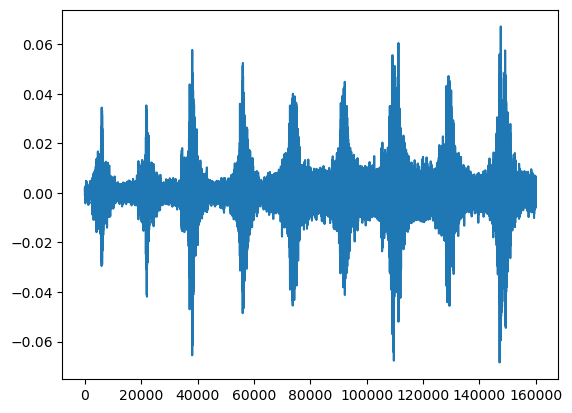

In [2]:
waveform_shape = 0
for support_set, _ in train_loader:
    for waveform, label in support_set:
        waveform = waveform.squeeze(0)
        print("波形形状: {}".format(waveform.size()))
        print("波形采样率: {}".format(sample_rate))
        plt.plot(waveform[0].T.numpy())
        waveform_shape = waveform.shape
        break
    break

Epoch:4  |  CNN_Loss :5.055
Epoch:8  |  CNN_Loss :2.839
Epoch:12  |  CNN_Loss :2.400
Epoch:16  |  CNN_Loss :2.109
Epoch:20  |  CNN_Loss :2.013
Epoch:24  |  CNN_Loss :2.219
Epoch:28  |  CNN_Loss :2.065
Epoch:32  |  CNN_Loss :2.171
Epoch:36  |  CNN_Loss :2.187
Epoch:40  |  CNN_Loss :2.023
Epoch:44  |  CNN_Loss :2.111
Epoch:48  |  CNN_Loss :2.252
Epoch:52  |  CNN_Loss :2.115
Epoch:56  |  CNN_Loss :2.108
Epoch:60  |  CNN_Loss :2.166
Epoch:64  |  CNN_Loss :2.173


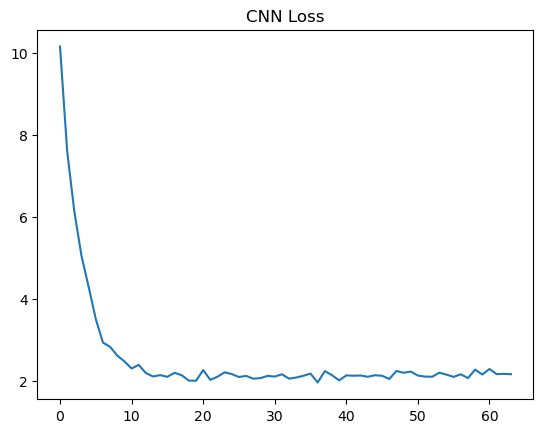

In [3]:
def cnn_train(cnn, train_loader, num_epochs, lr, device):

    def init_weights(module):
        if isinstance(module, nn.Linear) or isinstance(module, nn.Conv1d):
            nn.init.xavier_uniform_(module.weight)
        elif isinstance(module, torch_geometric.nn.GCNConv):
            nn.init.xavier_uniform_(module.lin.weight)

    def get_num_correct_query_pred(pred_y, y, support_size):
        return torch.sum(pred_y[support_size:].argmax(dim=1) == y[support_size:])

    optimizer = optim.Adam(cnn.parameters(), lr=lr, weight_decay=0.0001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
    loss_function = nn.CrossEntropyLoss()

    cnn.to(device).train()
    cnn.apply(init_weights)
    losses = []

    for epoch in range(1, num_epochs+1):
        metric = utils.Accumulator(2) # 一个epoch经过样本数 cnn一个epoch所有样本损失总量
        for support_set, query_set in train_loader:
            support_size, query_size = len(support_set), len(query_set)
            waveforms, labels = [], []
            for waveform, label in support_set:
                waveforms.append(waveform.squeeze(0)),
                labels.append(label)
            for waveform, label in query_set:
                waveforms.append(waveform.squeeze(0)),
                labels.append(label)
            waveforms = torch.stack(waveforms).to(device)
            labels = torch.tensor(labels, device=device)

            optimizer.zero_grad()
            y_hat = cnn(waveforms)
            loss = loss_function(y_hat, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            metric.add(waveforms.shape[0], loss.item())
        losses.append(metric[1])

        if epoch % 4 == 0 :
            print(f"Epoch:{epoch}  |  CNN_Loss :{metric[1]:.3f}")
    plt.plot(list(range(num_epochs)), losses, label='Loss')
    plt.title('CNN Loss')

import nets
cnn = nets.AudioCNN(embed_size=64, num_channels_input=8, 
                    num_channels_hidden=32, num_classes_output=32)
gcn = nets.GCN(num_features_inputs=64, num_classes_output=32)
cnn_train(cnn, train_loader, num_epochs=64, lr=0.01, device=args.device)

In [4]:
graphs = utils.to_graph_dataset(cnn, train_loader, device=args.device)
graph_dataset = datasets.GraphDataset(graphs=graphs)
query_size = mimii_dataset.query_size

from torch_geometric.loader import DataLoader as GeometricDataLoader
graph_trainloader = GeometricDataLoader(graph_dataset, batch_size=1, shuffle=True)
print(len(graph_trainloader))

3


在第0张图  |  Epoch:50  |  GCN_Loss :nan  |  Acc:0.00%
在第0张图  |  Epoch:100  |  GCN_Loss :nan  |  Acc:0.00%


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

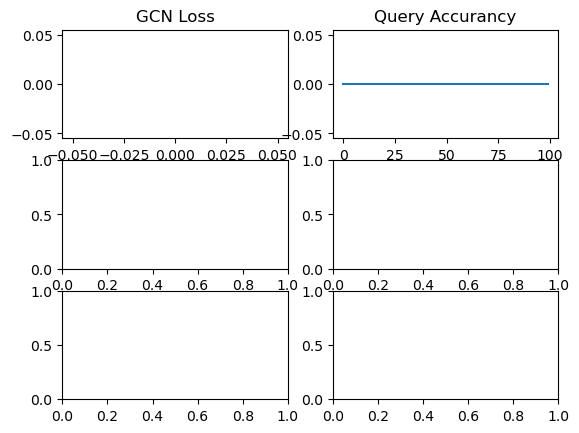

In [7]:
def gcn_train(gcn, graph_train_loader, query_size, num_epochs, lr, device):

    def init_weights(module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
        elif isinstance(module, torch_geometric.nn.GCNConv):
            nn.init.xavier_uniform_(module.lin.weight)

    def get_num_correct_query_pred(pred_y, y, query_size):
        return torch.sum(pred_y[-query_size:].argmax(dim=1) == y[-query_size:])

    optimizer = optim.Adam(gcn.parameters(), lr=lr)
    loss_function = nn.CrossEntropyLoss()
    gcn.to(device).train()
    gcn.apply(init_weights)
    _, axes = plt.subplots(len(graph_train_loader), 2)
    for graph_idx, graph in enumerate(graph_train_loader):
        losses, accs = [], []
        x, y = graph.x.to(device), graph.y.to(device)
        edge_index, edge_weight = graph.edge_index.to(device), graph.edge_weight.to(device)
        for epoch in range(1, num_epochs+1):
            metric = utils.Accumulator(4) # 一个epoch经过样本数 gcn一个epoch所有样本损失总量 一个epoch的query总数 一个epoch正确分类的query总数
            optimizer.zero_grad()
            y_hat = gcn(x, edge_index, edge_weight)
            loss = loss_function(y_hat, y)
            loss.backward(retain_graph=True)
            optimizer.step()
            metric.add(x.shape[0], loss.item(),
                    query_size, get_num_correct_query_pred(y_hat, y, query_size))
            if epoch % 50==0:
                print(f"在第{graph_idx}张图  |  Epoch:{epoch}  |  GCN_Loss :{metric[1]:.3f}  |  Acc:{metric[3]/metric[2]*100:.2f}%")
            losses.append(metric[1])
            accs.append(metric[3]/metric[2])
        axes[graph_idx, 0].plot(list(range(num_epochs)), losses)
        axes[graph_idx, 0].set_title('GCN Loss')
        axes[graph_idx, 1].plot(list(range(num_epochs)), accs)
        axes[graph_idx, 1].set_title('Query Accurancy')
            
gcn_train(gcn, graph_trainloader, query_size, num_epochs=100, lr=0.025, device=args.device)